In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cuda


In [6]:
l2_norm_list = []
linf_norm_list = []

In [ ]:
# Параметры задачи
l = 2          # Длина стержня
T = 1          # Конечное время
n = 256         # Количество узлов длины стержня
m = 128         # Количество узлов времени T
h = l / n      # Шаг сетки по l
tau = T / m    # Шаг сетки по T

# Коэффициенты из задачи
C = 0.1        # Коэффициент C
a = 1          # Коэффициент a

# Начальные и граничные условия
def InitialCondition(x):
    # Начальное условие: u(x, t=0)
    return C * np.e ** (x)

def BoundaryLeftCondition(t):
    # Левое граничное условие: u(x=0, t)
    return C * np.e ** (a**2 * t)

def BoundaryRightCondition(t):
    # Правое граничное условие: u(x=l, t)
    return C * np.e ** (l + (a * a) * t)

def func(x):
    # Правая часть уравнения, в данном случае равна 0
    return 0

def pde(x, t, net):
    # Определение уравнения в частных производных
    u = net(x, t)  # Сеточная функция u(x, t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # Первая производная по x
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]  # Вторая производная по x
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]  # Первая производная по t
    pde = u_xx - u_t + func(x)  # Уравнение: u_xx - u_t + f(x)
    return pde

# Подготовка данных для обучения
x_bc = np.array([i * h for i in range(n)])  # Сетка по x для граничных условий
t_bc = np.array([i * tau for i in range(m)])  # Сетка по t для граничных условий

# Формирование граничных условий
bc_l = np.vstack([np.zeros((m)),    t_bc,  BoundaryLeftCondition(t_bc)]).T  # Левое граничное условие
bc_r = np.vstack([np.ones((m)) * l, t_bc,  BoundaryRightCondition(t_bc)]).T  # Правое граничное условие
ic   = np.vstack([x_bc,     np.zeros((n)), InitialCondition(x_bc)]).T  # Начальное условие

# Объединение начальных и граничных условий
initial_boundary_conditions = np.vstack([bc_l, bc_r, ic])
x_initial_bc = initial_boundary_conditions[:, 0].reshape(-1, 1)  # Координаты x для начальных и граничных условий
t_initial_bc = initial_boundary_conditions[:, 1].reshape(-1, 1)  # Координаты t для начальных и граничных условий
u_initial_bc = initial_boundary_conditions[:, 2].reshape(-1, 1)  # Значения u для начальных и граничных условий

# Преобразование данных в тензоры
pt_x_initial_bc = torch.autograd.Variable(torch.from_numpy(x_initial_bc).float(), requires_grad=False).to(device)
pt_t_initial_bc = torch.autograd.Variable(torch.from_numpy(t_initial_bc).float(), requires_grad=False).to(device)
pt_u_initial_bc = torch.autograd.Variable(torch.from_numpy(u_initial_bc).float(), requires_grad=False).to(device)


# Создание структурированной сетки для внутренних узлов
x_collocation = np.linspace(0, l, n+1)[1:-1]  # Узлы по x без учета граничных точек
t_collocation = np.linspace(0, T, m+1)[1:]    # Узлы по t без начальной точки

# Создание структурированной сетки
X_struct, T_struct = np.meshgrid(x_collocation, t_collocation)

# Преобразование двумерной сетки в список координат 
x_collocation_reshaped = X_struct.flatten().reshape(-1, 1)  # Все координаты x
t_collocation_reshaped = T_struct.flatten().reshape(-1, 1)  # Все координаты t

# Конвертация в PyTorch тензоры
pt_x_collocation = torch.autograd.Variable(torch.from_numpy(x_collocation_reshaped).float(), requires_grad=True).to(device)
pt_t_collocation = torch.autograd.Variable(torch.from_numpy(t_collocation_reshaped).float(), requires_grad=True).to(device)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

--- 39.90331816673279 seconds ---


AttributeError: Line2D.set() got an unexpected keyword argument 'title'

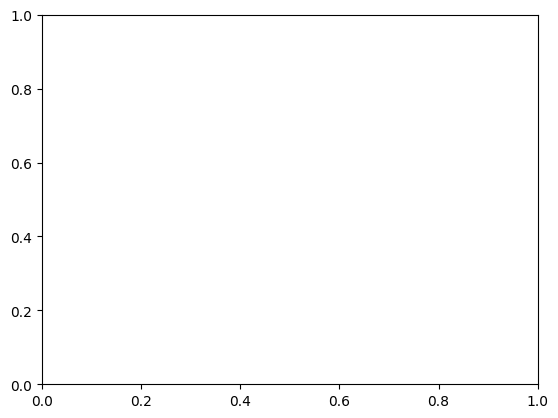

In [ ]:
# @title Архитектура нейронной сети
class Net(nn.Module):
    def __init__(self, in_features, mid_features, out_features):
        super(Net,self).__init__()
        self.lin_linear_1 = self.make_layer(in_features, mid_features * 1)
        self.lin_linear_2 = self.make_layer(mid_features * 1, mid_features * 2)
        self.lin_linear_3 = self.make_layer(mid_features * 2, mid_features * 2)
        self.lin_linear_4 = self.make_layer(mid_features * 2, out_features)
        self.tanh = F.tanh

    def make_layer(self,in_f,out_f):
        return nn.Linear(in_f,out_f)

    def forward(self, x, t):
        inputs = torch.cat([x, t], axis=1)
        x = self.lin_linear_1(inputs)
        x = self.tanh(x)
        x = self.lin_linear_2(x)
        x = self.tanh(x)
        x = self.lin_linear_3(x)
        x = self.tanh(x)
        x = self.lin_linear_4(x)
        return x
    


# Настройка оптимайзера и нейросети, loss MSE
MAX_EPOCHS = 100
net = Net(2, 6, 1)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(list(net.parameters()), lr=0.05) #требует определения closure

#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


# @title Training / Fitting
def get_loss(pt_x_collocation, pt_t_collocation, batch_size=None):
    net_bc_ic_out = net(pt_x_initial_bc, pt_t_initial_bc)
    mse_bc_ic_u = mse_cost_function(net_bc_ic_out, pt_u_initial_bc)

    all_zeros = np.zeros((n,1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    # PDE потери для всей сетки или батчами
    mse_pde = 0
    if batch_size:
        # Разбиваем на батчи
        num_points = pt_x_collocation.shape[0]
        for i in tqdm(range(0, num_points, batch_size), desc="Collocation Loss", leave=False):
            x_batch = pt_x_collocation[i:i + batch_size]
            t_batch = pt_t_collocation[i:i + batch_size]
            pde_out = pde(x_batch, t_batch, net)
            mse_pde += mse_cost_function(pde_out, torch.zeros_like(pde_out))
    else:
        # Полная обработка сетки
        pde_out = pde(pt_x_collocation, pt_t_collocation, net)
        mse_pde = mse_cost_function(pde_out, torch.zeros_like(pde_out))

    return mse_bc_ic_u + mse_pde

losses = np.zeros((MAX_EPOCHS,1))
pbar = tqdm(range(MAX_EPOCHS), desc="Training", leave=True)
start_time = time.time()
i = 0
for epoch in pbar:
    net.train()

    # Определяем `closure` внутри цикла
    def closure():
        loss = get_loss(pt_x_collocation, pt_t_collocation)
        optimizer.zero_grad()
        # Назад распространяем градиенты
        loss.backward()
        return loss

    
    # Шаг оптимизатора
    optimizer.step(closure)

    loss = get_loss(pt_x_collocation, pt_t_collocation, batch_size=None)
    # Сохраняем значения `loss` для графика
    losses[i] = (loss.detach().cpu().numpy().item())
    i += 1 
    # Обновляем описание прогресс-бара
    pbar.set_description(f"Epoch {epoch+1}/{MAX_EPOCHS} | Loss: {loss:.10f}")
    

print("--- %s seconds ---" % (time.time() - start_time))

# @title График Loss
plt.plot(np.arange(0,MAX_EPOCHS,1),losses, label="loss")
plt.grid()
plt.title("Residual MSE_PDE + MSE_BC_IC")
plt.xlabel = "Epochs"
plt.ylabel = "losses"
plt.legend()
plt.show()


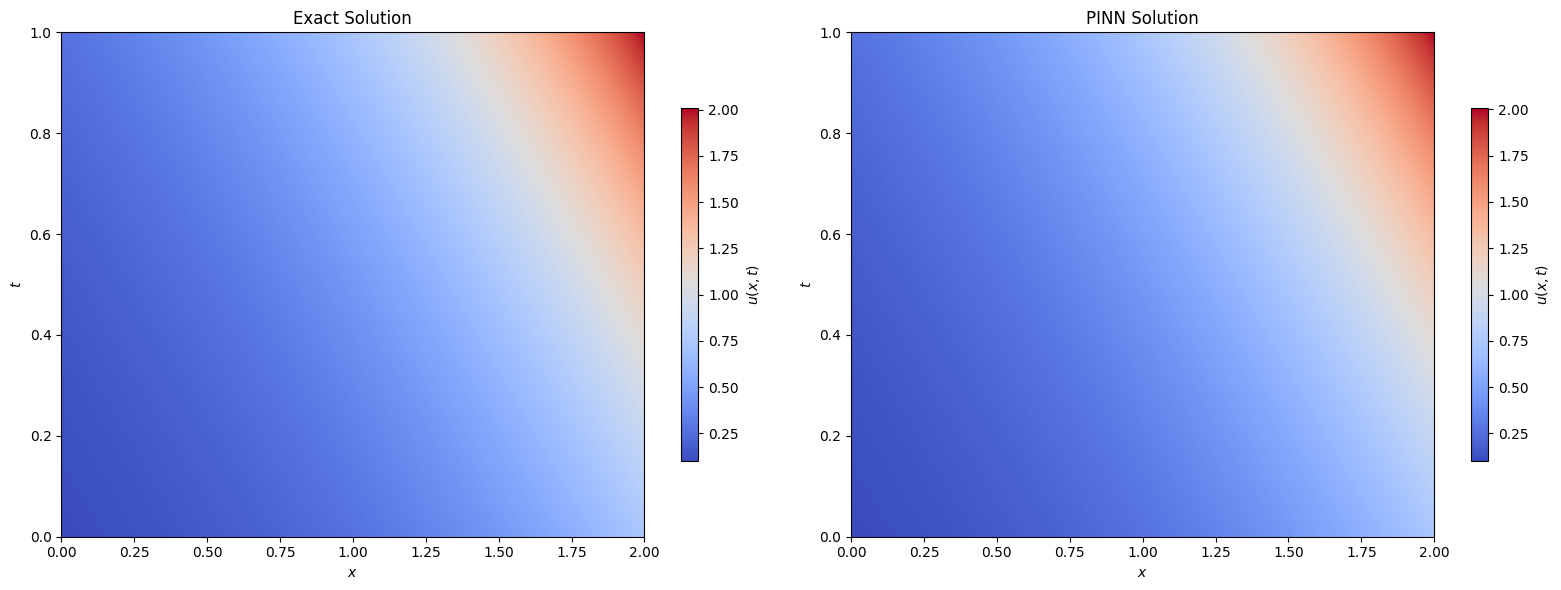

In [25]:
# @title Точное
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def exact(x, t):
    return C * np.e ** (x + (a * a) * t )

x=np.linspace(0, l, n+1)
t=np.linspace(0, T, m+1)
ms_x, ms_t = np.meshgrid(x, t)

x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)


u = exact(x, t)
ms_u = u.reshape(ms_x.shape)


x=np.linspace(0, l, n+1)
t=np.linspace(0, T, m+1)
ms_x, ms_t = np.meshgrid(x, t)

x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_y = net(pt_x, pt_t)
y = pt_y.data.cpu().numpy()
ms_y = y.reshape(ms_x.shape)




fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title("Exact Solution")
im1 = axes[0].imshow(ms_u, extent=[0, l, 0, T], origin='lower', aspect='auto', cmap='coolwarm')
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$t$")
fig.colorbar(im1, ax=axes[0], shrink=0.7, label=r"$u(x, t)$")

# Приближенное решение
axes[1].set_title("PINN Solution")
im2 = axes[1].imshow(ms_y, extent=[0, l, 0, T], origin='lower', aspect='auto', cmap='coolwarm')
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$t$")
fig.colorbar(im2, ax=axes[1], shrink=0.7, label=r"$u(x, t)$")

plt.tight_layout()
plt.show()


In [26]:
import numpy as np

# Вычисляем точное решение
u_exact = ms_u.ravel()  # Точное решение (плоский массив)
u_pred = ms_y.ravel()   # Приближенное решение (плоский массив)

# L2-норма
l2_norm = np.sqrt(np.mean((u_exact - u_pred) ** 2))
l2_norm_list.append([n, m , l2_norm])
# L∞-норма
linf_norm = np.max(np.abs(u_exact - u_pred))
linf_norm_list.append([n, m , linf_norm])

print(f"L2-норма: {l2_norm:.6f}")
print(f"L∞-норма: {linf_norm:.6f}")

L2-норма: 0.000128
L∞-норма: 0.000774
